In [2]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [4]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'  # Assuming 2 classes
)

val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'  # Assuming 2 classes
)

import os
import shutil

# Move all test images into a dummy folder called 'unknown'
test_subdir = os.path.join(test_dir, 'unknown')
os.makedirs(test_subdir, exist_ok=True)

for filename in os.listdir(test_dir):
    file_path = os.path.join(test_dir, filename)
    if os.path.isfile(file_path):
        shutil.move(file_path, os.path.join(test_subdir, filename))

test_data_gen = test_image_generator.flow_from_directory(
    directory=test_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,     # No labels in test
    shuffle=False
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


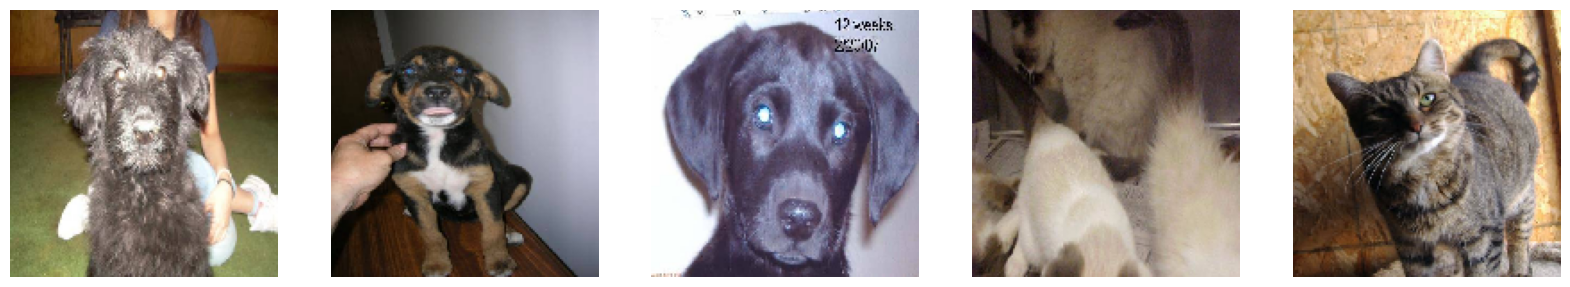

In [5]:
#4
def plotImages(images_arr, probabilities=False):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20, 20))  # 1 row instead of many
    if probabilities is False:
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)
            ax.axis('off')
    else:
        for img, probability, ax in zip(images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis('off')
            if probability > 0.5:
                ax.set_title(f"{probability*100:.2f}% dog")
            else:
                ax.set_title(f"{(1-probability)*100:.2f}% cat")
    plt.show()

# Use the correctly named train_data_gen
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [6]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,          # Always normalize pixel values
    rotation_range=40,       # Randomly rotate images in the range (degrees)
    width_shift_range=0.2,   # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,         # Shear intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Flip images horizontally
    fill_mode='nearest'      # Fill in new pixels after rotation/shift
)

Found 2000 images belonging to 2 classes.


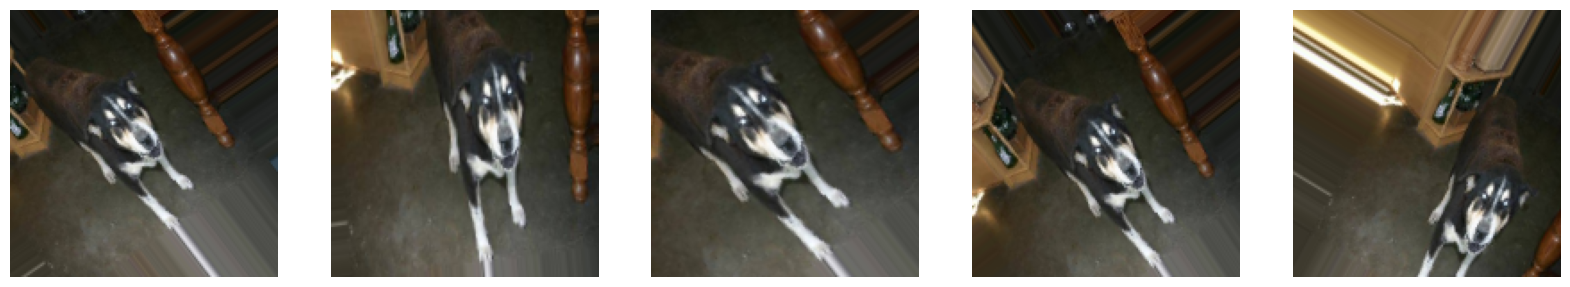

In [7]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [8]:
# 7
model = Sequential([
    # First convolution + pooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    # Second convolution + pooling
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Third convolution + pooling
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten & dense layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Helps prevent overfitting

    # Output layer (2 classes → sigmoid for binary classification)
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 8
history = model.fit(
    train_data_gen,                 # Training data
    steps_per_epoch=len(train_data_gen),  # Number of batches per epoch
    epochs=15,                       # You can change based on performance
    validation_data=val_data_gen,    # Validation data
    validation_steps=len(val_data_gen)   # Number of batches in validation
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 132s 8s/step - accuracy: 0.4960 - loss: 0.9941 - val_accuracy: 0.5310 - val_loss: 0.6916
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 129s 8s/step - accuracy: 0.5401 - loss: 0.6899 - val_accuracy: 0.5720 - val_loss: 0.6795
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 129s 8s/step - accuracy: 0.5645 - loss: 0.6772 - val_accuracy: 0.5790 - val_loss: 0.6740
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 146s 8s/step - accuracy: 0.5988 - loss: 0.6613 - val_accuracy: 0.6050 - val_loss: 0.6799
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 137s 9s/step - accuracy: 0.5727 - loss: 0.6804 - val_accuracy: 0.5980 - val_loss: 0.6813
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 135s 8s/step - accuracy: 0.6006 - loss: 0.6707 - val_accuracy: 0.6140 - val_loss: 0.6646
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 138s 8s/step - accuracy: 0.6253 - loss: 0.6577 - val_accuracy: 0.5650 - val_loss: 0.6659
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 134s 8s/step - accuracy: 0.6220 - loss: 0.6508 - val_accuracy: 0.6590 - v

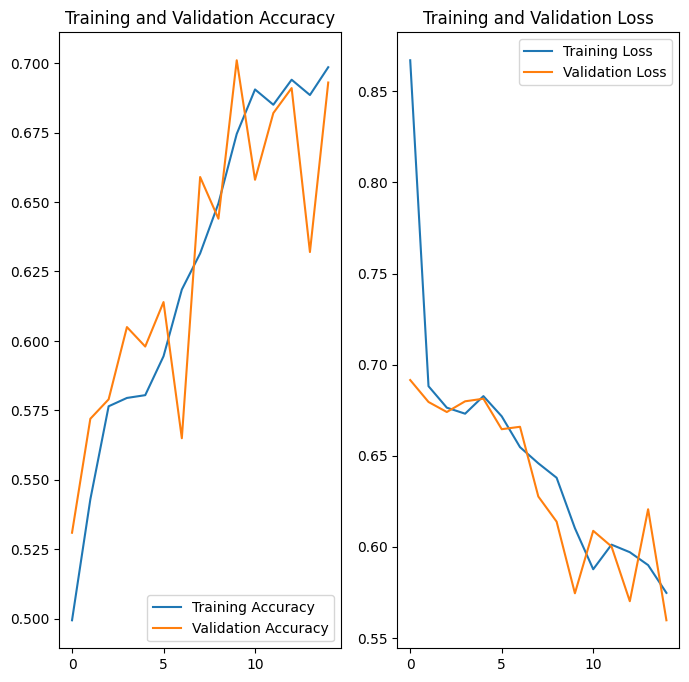

In [11]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step


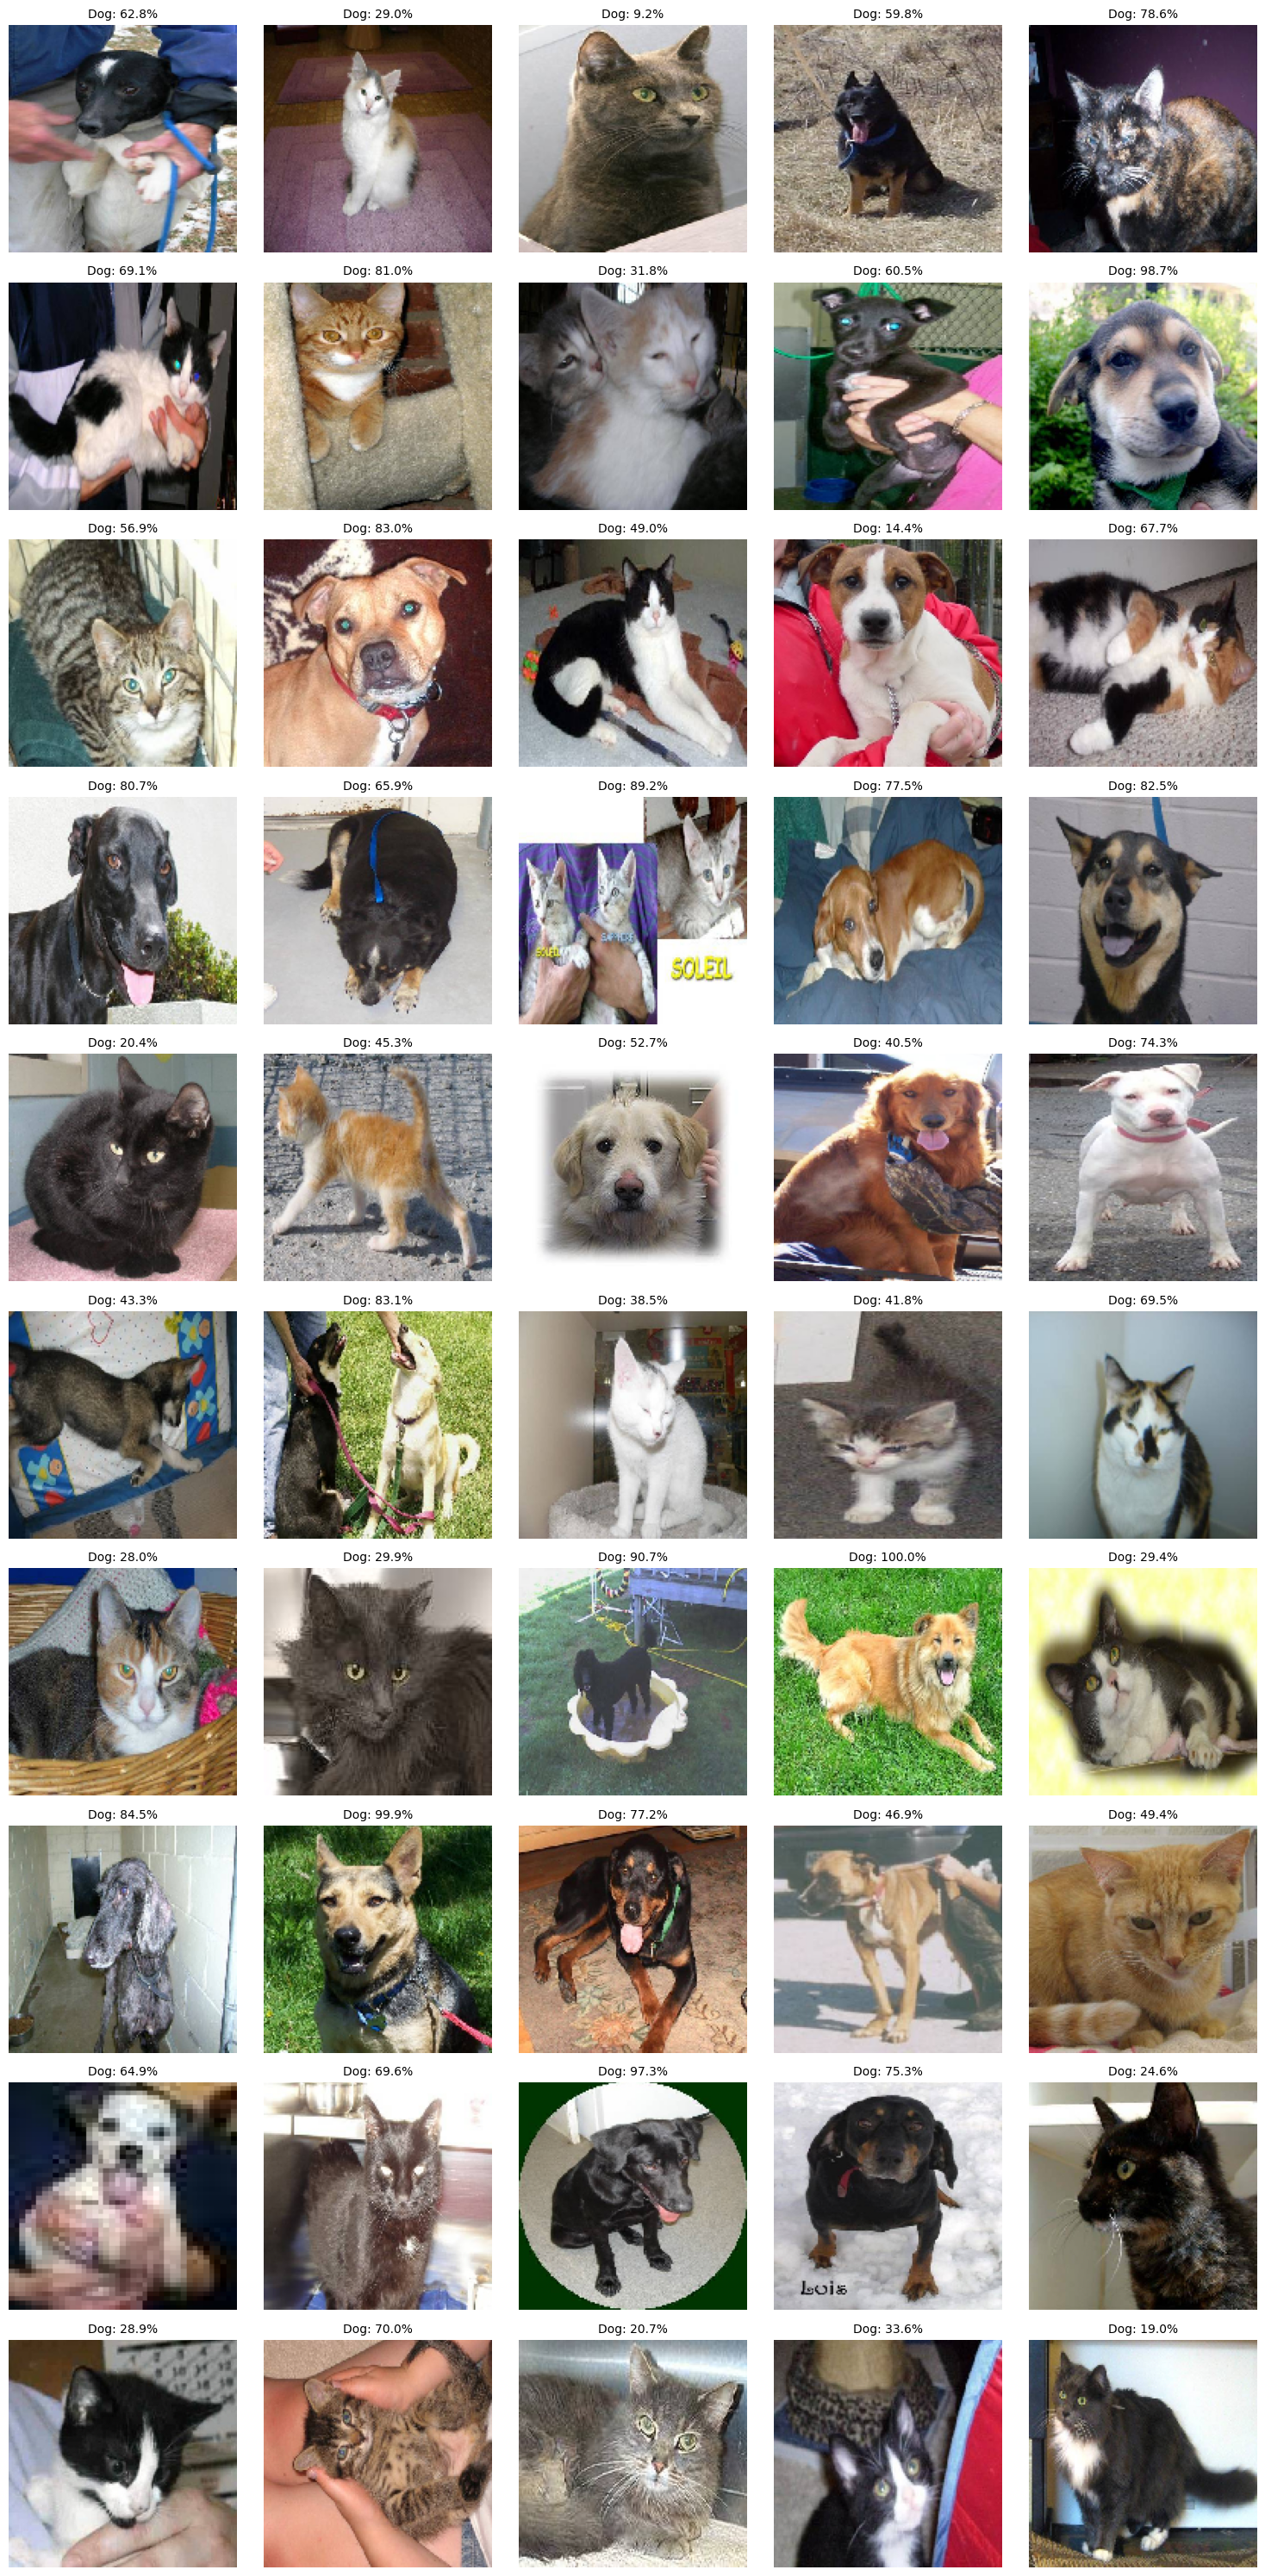

In [14]:
test_batch = next(test_data_gen)

# Handle whether labels exist or not
if isinstance(test_batch, tuple):
    test_images = test_batch[0]
else:
    test_images = test_batch

# Predict probabilities
probabilities = model.predict(test_images)

# For binary classification, take dog probability (second column if using softmax, or single sigmoid output)
if probabilities.shape[1] == 2:
    dog_probabilities = probabilities[:, 1]  # probability of dog
else:
    dog_probabilities = probabilities[:, 0]  # sigmoid output

# Plot neatly without overlapping labels
num_images = len(test_images)
cols = 5  # images per row
rows = int(np.ceil(num_images / cols))

plt.figure(figsize=(cols * 3, rows * 3))
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.title(f"Dog: {dog_probabilities[i]*100:.1f}%", fontsize=10)

plt.tight_layout()
plt.show()

In [16]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
    # If softmax output (2 classes), take the second column for 'dog'
    if probability.shape[0] == 2:
        prob_value = probability[1]
    else:
        prob_value = probability[0]  # sigmoid output

    if round(prob_value) == answer:
        correct += 1

percentage_identified = (correct / len(answers)) * 100
passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
    print("You passed the challenge!")
else:
    print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")


Your model correctly identified 74.0% of the images of cats and dogs.
You passed the challenge!
